In [1]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb()
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from numpy import sqrt
import jax
import jax.numpy as jnp
import numpyro.distributions as dist

/Users/tbent/.mambaforge/envs/confirm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
n = 50
p = 0.2
t = jax.scipy.special.logit(p)
At = lambda t: -n * jnp.log(1 - jax.scipy.special.expit(t))
g = lambda t, x: t * x - At(t)
dg = jax.grad(g)
dg_vmap = jax.vmap(dg, in_axes=(None, 0))
dgg_vmap = jax.vmap(jax.grad(dg), in_axes=(None, 0))

holderp = 1.2
holderq = 1.0 / (1 - 1.0 / holderp)

### The constant term

Compute the constant term using both a numerical sum and using the 6th moment formula from wikipedia

In [7]:
# numerical integral to compute E[ |grad g|^q]^(1/q)
# need to compute for the worst t in the "tile".
# def C_numerical(t, q):
#     p = jax.scipy.special.expit(t)
#     xs = jnp.arange(n + 1).astype(jnp.float64)
#     eggq = jnp.abs(xs - n * p) ** q
#     return sum(eggq * scipy.stats.binom.pmf(xs, n, p)) ** (1 / q)
    
def C_numerical(t, q):
    p = jax.scipy.special.expit(t)
    xs = jnp.arange(n + 1).astype(jnp.float64)
    return jnp.exp((1 / q) * jax.scipy.special.logsumexp(
        q * jnp.log(jnp.abs(xs - n * p))
        + dist.Binomial(n, p).log_prob(xs)
    ))

# Formula for C with q = 6 from wikipedia
def C_wiki(p, q):
    assert(q == 6)
    return (n * p * (1 - p) * (1 - 30 * p * (1 - p) * (1 - 4 * p * (1 - p)) + 5 * n * p * (1 - p) * (5 - 26 * p * (1 - p)) + 15 * n ** 2 * p ** 2 * (1 - p) ** 2)) ** (1 / 6)

# p = 0.2 corresponds to t=-1.386
# choose theta = -1.1 as the edge of our tile.
# so our tile is going to extend unidirectionally from -1.386 (the grid pt) to -1.1
# since the constant is monotonic in the relevant region, we can just compute
# at the edge of the tile to get a maximum value.
tmax = -1.1
pmax = jax.scipy.special.expit(tmax)
# C = C_wiki(pmax)
C = C_numerical(tmax, holderq)
C_numerical(tmax, 6), C_wiki(pmax, 6)

(DeviceArray(4.81013915, dtype=float64),
 DeviceArray(4.81013915, dtype=float64, weak_type=True))

### Is the constant term monotonic? 

For even integer q: It's unimodal. Monotonic in [0, 0.5] and separately in [0.5, 1].

For q < 2: there are tons of micro peaks...

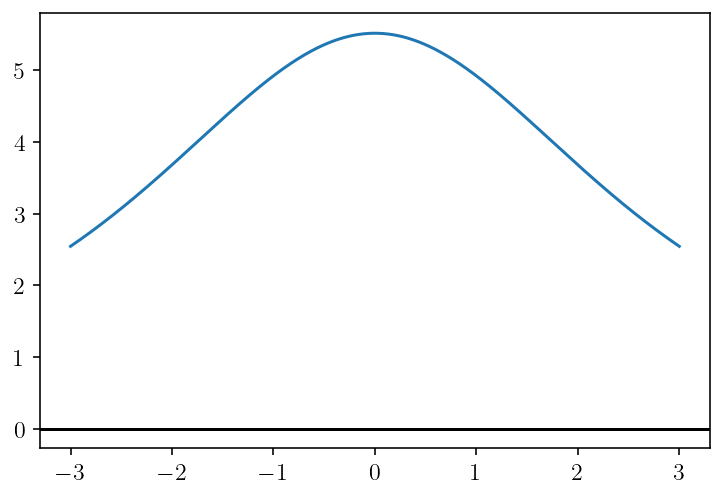

In [8]:
domain = [-3, 3]
ts = np.linspace(*domain, 1000)
cs = jax.jit(jax.vmap(C_numerical, in_axes=(0, None)))(ts, holderq)
plt.plot(ts, cs, label="C")
# cgs = jax.jit(jax.vmap(jax.grad(C_numerical), in_axes=(0, None)))(ts, q)
# plt.plot(ts, cgs, label="dC/dtheta")
# cggs = jax.jit(jax.vmap(jax.grad(jax.grad(C_numerical)), in_axes=(0, None)))(ts, q)
# plt.plot(ts, cggs, label="d2C/dtheta2")
plt.axhline(0, color="black")
plt.show()

## Computing bounds for a simple binomial test.

For holder bounds, it's only necessary to choose a Type I Error value. 

But, to compute a classical gradient, it helps to have a real test that we're considering.

Here, we choose a test where we reject the null if x >= 19 and n=50. 

We're considering a tile where true p at the center of the tile is 0.2 and true theta is -1.38

The true Type I Error should be ~0.093%:

In [11]:
thresh = 20
# the minus 1 is to account for cdf = p(x <= x) and we want p(x >= x)
1 - scipy.stats.binom.cdf(thresh - 1, n, p)

0.0009324364894210957

### Simulation

In [12]:
delta = 0.01
nsims=int(1e4)
np.random.seed(0)
samples = scipy.stats.binom.rvs(n, p, size=nsims)
reject = samples >= thresh
typeI_sum = np.sum(reject)
typeI_est = typeI_sum / nsims
typeI_CI = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum) - typeI_est
typeI_est, typeI_CI

(0.0011, 0.0010478639746356723)

### Holder-ODE solution

In [13]:
# use the upper bound on t1e
f0 = typeI_est + typeI_CI

# integration distance to reach the edge of the tile.
dt = tmax - t
t_path = np.linspace(t, t + dt, 100)

analytical = ((t_path - t) * C / holderq + f0 ** (1 / holderq)) ** holderq

### Classical bound

In [14]:
delta_prop_0to1 = 0.5
typeI_CI_classic = scipy.stats.beta.ppf(1 - (delta * delta_prop_0to1), typeI_sum + 1, nsims - typeI_sum) - typeI_est

grad_est = np.sum(reject * (samples - n * p)) / nsims

covar = n * p * (1 - p)
grad_bound = np.sqrt(covar / nsims * (1 / ((1 - delta_prop_0to1) * delta) - 1))

# use pmax for a worst case hessian bound.
hess_bound = n * pmax * (1 - pmax)

Comparing gradient estimates: In this regime, classical gradient bound is ~10x larger than the Holder gradient bound. So, Holder gradient bound could be substituted in here for an improvement.

In [15]:
grad_est + grad_bound, C * f0 ** (1 / holderp)

(0.41129874686520007, DeviceArray(0.02876272, dtype=float64))

In [16]:
classical = typeI_est + typeI_CI_classic + (grad_est + grad_bound) * (t_path - t) + 0.5 * hess_bound * (t_path - t) ** 2

### Second order Holder-ODI.


In [17]:
f1 = min(C * f0 ** (1/holderp), grad_est + grad_bound)
holderp2 = 1.2
holderq2 = 1.0 / (1 - 1.0 / holderp2)
def C2_numerical(t, p, q):
    xs = jnp.arange(n + 1).astype(jnp.float64)
    integrand = jnp.abs(dg_vmap(t, xs) ** 2 + dgg_vmap(t, xs)) ** q
    return sum(integrand * scipy.stats.binom.pmf(xs, n, p)) ** (1 / q)
C2 = C2_numerical(tmax, pmax, holderq2)
ts2 = np.linspace(-10, 10, 100)
cs2 = [C2_numerical(t, jax.scipy.special.expit(t), holderq2) for t in ts]
# plt.plot(ts2, cs2)
# plt.show()
def derivs2(_, y):
    cur_f = y[0]
    fp = y[1]
    fpp = C2 * cur_f ** (1 / holderp2)
    return [fp, fpp]
result2 = scipy.integrate.solve_ivp(derivs2, (t, t+dt), [f0, f1], t_eval=t_path, rtol=1e-10, atol=1e-10)
holderode2 = result2['y'][0]
# holderode2

### Centering

In [18]:
a = 0.01
hp = 1.2

def fc(c, a, p):
    return (a * (1 - c) ** p + (1 - a) * c ** p) ** (1 / p)

def copt(a, p):
    return 1 / (1 + ((1-a)/a)**(1/(p-1)))

print(fc(0, a, hp))
print(copt(a, hp))
print(fc(copt(a, hp), a, hp))
print(fc(0, a, hp) - fc(copt(a, hp), a, hp))

0.021544346900318832
1.0515357127027733e-10
0.021544346899941256
3.775764423341599e-13


/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_83834/3085880235.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(avs, np.log10(change), 'r-', label=r'$\log_{10} \Delta \|F - c\|_p$')


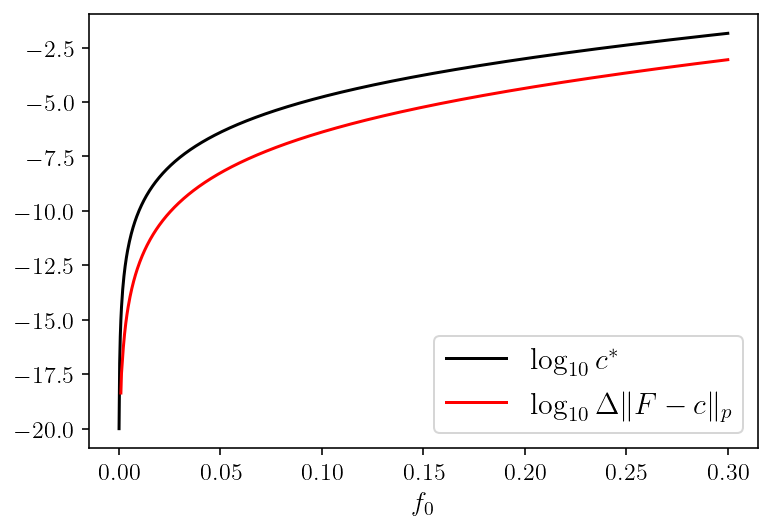

In [19]:
avs = np.linspace(0.0001, 0.3, 1000)
co = copt(avs, hp)
change = fc(0, avs, hp) - fc(copt(avs, hp), avs, hp)
plt.plot(avs, np.log10(co), 'k-', label=r'$\log_{10} c^*$')
plt.plot(avs, np.log10(change), 'r-', label=r'$\log_{10} \Delta \|F - c\|_p$')
plt.xlabel('$f_0$')
plt.legend()
plt.show()

In [20]:
for a in np.linspace(0.001, 0.2, 10):
    print(1.0 / (1 + ((1 - a) / a) ** (1 / (holderp - 1))))

1.0050150350701191e-15
7.411024935503599e-09
2.3836796215465226e-07
1.961179950492769e-06
9.145988273934425e-06
3.1209806952531345e-05
8.742839269134588e-05
0.00021387042348535218
0.00047411704369847054
0.0009756097560975597


### Centering bound

In [24]:
centeredp = 1.2
centeredq = 1.0 / (1 - 1.0 / centeredp)
C_centered = C_numerical(tmax, centeredq)
def derivs(_, y):
    cur_f = y[0]
    c = copt(cur_f, centeredp)
    cur_Fc = cur_f * (1 - c) ** centeredp + (1 - cur_f) * c ** centeredp
    return C_centered * cur_Fc ** (1 / centeredp)
centeredode = scipy.integrate.solve_ivp(derivs, (t, t+dt), [f0], t_eval=t_path, rtol=1e-10, atol=1e-10)
centeredsoln = centeredode['y'][0]

## Comparing bounds

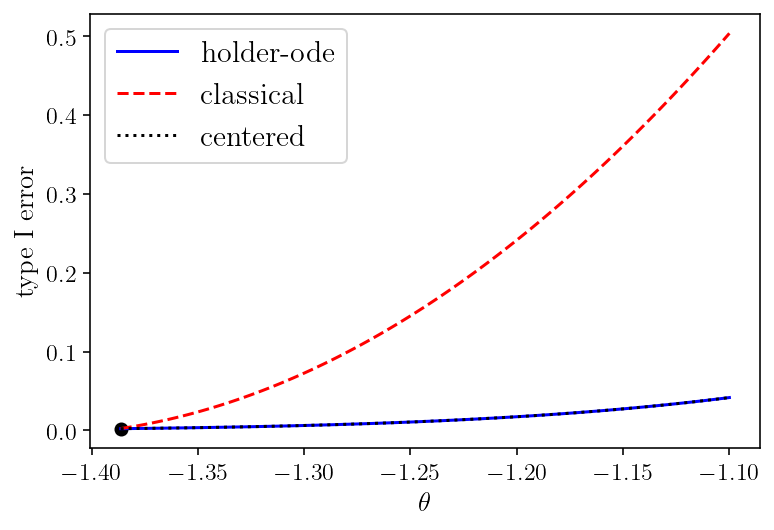

In [25]:
plt.plot([t], [f0], 'ko')
plt.plot(t_path, analytical, 'b-', label='holder-ode')
plt.plot(t_path, classical, 'r--', label='classical')
plt.plot(t_path, centeredsoln, 'k:', label='centered')
# plt.plot(t_path, holderode2, 'k--', label='holder-ode2')
plt.xlabel(r'$\theta$')
plt.ylabel('type I error')
plt.legend()
plt.show()

In [26]:
1 - scipy.stats.binom.cdf(thresh - 1, n, scipy.special.expit(-1.0))

0.03015068484022465

Computing the bound at the upper edge of the tile.

In [27]:
analytical[-1], classical[-1]

(DeviceArray(0.04163348, dtype=float64),
 DeviceArray(0.50397088, dtype=float64))

Computing the point where the bound crosses 0.025 and then compute the maximum cell size that would avoid the bound crossing 0.025.

In [28]:
holder_idx = np.argmin(analytical < 0.025)
classical_idx = np.argmin(classical < 0.025)
holder_cell_size = (t_path[holder_idx] - t)
classical_cell_size = (t_path[classical_idx] - t)

t_path[holder_idx], t_path[classical_idx], holder_cell_size, classical_cell_size

(-1.157837244670685,
 -1.3458082898504111,
 DeviceArray(0.22845712, dtype=float64),
 DeviceArray(0.04048607, dtype=float64))

The ratio of cell sizes. This is a guess at the ratio of the number of cells that would be required if we switched to using holder in regions of comparably low T1E. This corresponds to a reduction of 500x in the number of tiles required for a 4D problem with low T1E.

In [29]:
holder_cell_size / classical_cell_size

DeviceArray(5.64285714, dtype=float64)

## Checking the ODE integrator

Against the analytical solution

In [30]:
def derivs(_, y):
    cur_f = y[0]
    return C * cur_f ** (1 / holderp)
holderode = scipy.integrate.solve_ivp(derivs, (t, t+dt), [f0], t_eval=t_path, rtol=1e-10, atol=1e-10)

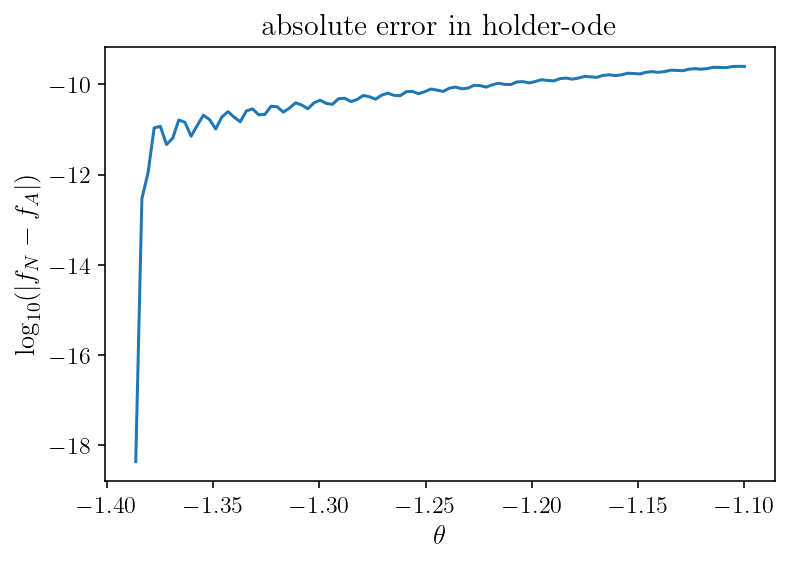

In [31]:
error = analytical - holderode['y'][0,:]
plt.plot(t_path, np.log10(np.abs(error)))
plt.title('absolute error in holder-ode')
plt.xlabel(r'$\theta$')
plt.ylabel('$\log_{10}(|f_N - f_A|)$')
plt.show()

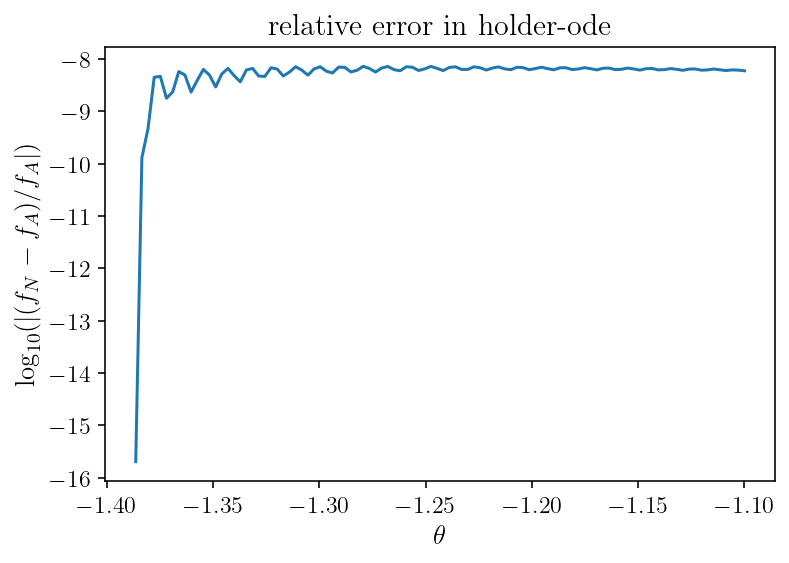

In [32]:
plt.plot(t_path, np.log10(np.abs(error / analytical)))
plt.title('relative error in holder-ode')
plt.xlabel(r'$\theta$')
plt.ylabel('$\log_{10}(|(f_N - f_A) / f_A|)$')
plt.show()